# Semantic Segmentation Demo

This example shows the usage of Deeplabv3 with MobileNetv1 as an image encoder. The model is pre-trained on the PASCAL VOC dataset for the task of semantic segmentation. 

Typical process for semantic segmentation involves:

1. ***Choose a Pre-trained Model:*** Select a pre-trained segmentation model. In this example, it is DeepLabv3 with MobileNetv1.
2. ***Preprocess Input Image:*** Preprocess the input image to match the requirements of the pre-trained model. This typically involves resizing, normalization, and any other preprocessing steps required by the specific model.
3. ***Generate segmentation mask:*** Perform a forward pass of the input image through the pre-trained model to obtain the segmentation output. The model will output a segmentation mask representing the predicted segmentation of objects in the input image.

## STEP 1: Pre-trained model
Creating a model is simple. You need a configuration file and the path to the pre-trained weights. Below is an example code snippet

In [3]:
from corenet.options.opts import get_training_arguments
from corenet.modeling import get_model
from PIL import Image
import torch
from torchvision.transforms import Compose, Resize, PILToTensor
from torchvision.transforms import ToPILImage
import os


# configuration file path
config_file = os.path.join(
    os.getcwd(),
    "..",
    "projects/range_augment/segmentation/pascal_voc/deeplabv3_mobilenet_v1.yaml",
)
# pre-trained weights
pretrained_weights = "https://docs-assets.developer.apple.com/ml-research/models/cvnets-v2/examples/range_augment/segmentation/pascal_voc/deeplabv3_mobilenet_v1.pt"

opts = get_training_arguments(
    args=[
        "--common.config-file",
        config_file,
        "--model.segmentation.pretrained",
        pretrained_weights,
    ]
)

# build the model
model = get_model(opts)
# set the model in evaluation mode.
model.eval()

2024-04-15 11:43:54 - LOGS    - Pretrained weights are loaded from /tmp/corenet/docs-assets.developer.apple.com/ml-research/models/cvnets-v2/examples/range_augment/classification/mobilenetv1_1.0.pt
2024-04-15 11:43:54 - INFO    - Trainable parameters: ['neural_augmentor.brightness._low', 'neural_augmentor.brightness._high', 'neural_augmentor.contrast._low', 'neural_augmentor.contrast._high', 'neural_augmentor.noise._low', 'neural_augmentor.noise._high', 'conv_1.block.conv.weight', 'conv_1.block.norm.weight', 'conv_1.block.norm.bias', 'layer_1.0.dw_conv.block.conv.weight', 'layer_1.0.dw_conv.block.norm.weight', 'layer_1.0.dw_conv.block.norm.bias', 'layer_1.0.pw_conv.block.conv.weight', 'layer_1.0.pw_conv.block.norm.weight', 'layer_1.0.pw_conv.block.norm.bias', 'layer_2.0.dw_conv.block.conv.weight', 'layer_2.0.dw_conv.block.norm.weight', 'layer_2.0.dw_conv.block.norm.bias', 'layer_2.0.pw_conv.block.conv.weight', 'layer_2.0.pw_conv.block.norm.weight', 'layer_2.0.pw_conv.block.norm.bias', 

SegEncoderDecoder(
  (encoder): MobileNetv1(
    (neural_augmentor): DistributionNeuralAugmentor(
    	Brightness=UniformSampler(min_fn=Clip(min=0.1, max=0.9, clipping=soft), max_fn=Clip(min=1.1, max=10.0, clipping=soft)), 
    	Contrast=UniformSampler(min_fn=Clip(min=0.1, max=0.9, clipping=soft), max_fn=Clip(min=1.1, max=10.0, clipping=soft)), 
    	Noise=UniformSampler(min_fn=Clip(min=0.0, max=5e-05, clipping=soft), max_fn=Clip(min=0.0001, max=1.0, clipping=soft)), )
    (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, normalization=BatchNorm2d, activation=ReLU)
    (layer_1): Sequential(
      (0): SeparableConv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, dilation=1)
    )
    (layer_2): Sequential(
      (0): SeparableConv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, dilation=1)
      (1): SeparableConv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, dilation=1)
    )
    (layer_3): Sequential(
    

## STEP 2: Read and pre-process input image

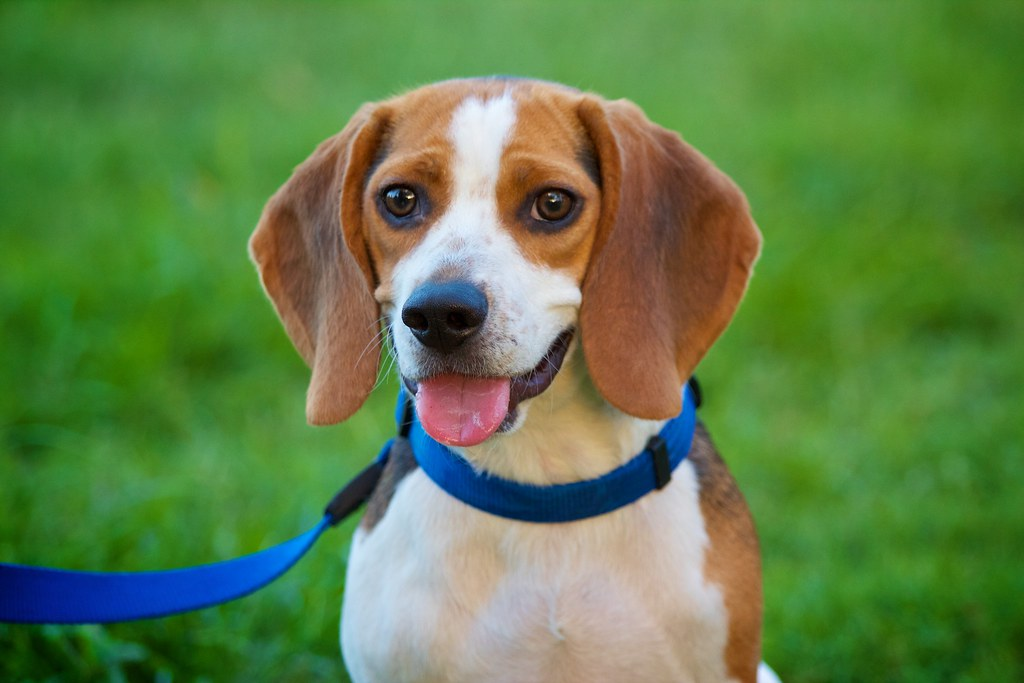

In [4]:
# Step 2.1: Read a PIL image and convert to RGB format.
img_path = os.path.join(os.getcwd(), "..", "assets", "dog.jpeg")
image = Image.open(img_path).convert("RGB")
image

In [5]:
## STEP 2.2: Preprocess an input image
# The model is fine-tuned on the semantic segmentation using 512x512 resolution. Therefore, we resize the input PIL image while maintaining the
# aspect ratio such that the shorter image dimension is 512. After that, we convert the resized PIL image into a tensor. The values in tensor
# range between 0 and 255. We covert it to float and normalize it between 0.0 and 1.0 by dividing the tensor by 255.

img_transforms = Compose([Resize(size=512), PILToTensor()])

input_tensor = img_transforms(image)
input_tensor = input_tensor.to(torch.float).div(255.0)

# add dummy batch dimension
input_tensor = input_tensor[None, ...]

## STEP 3: Generate segmentation mask

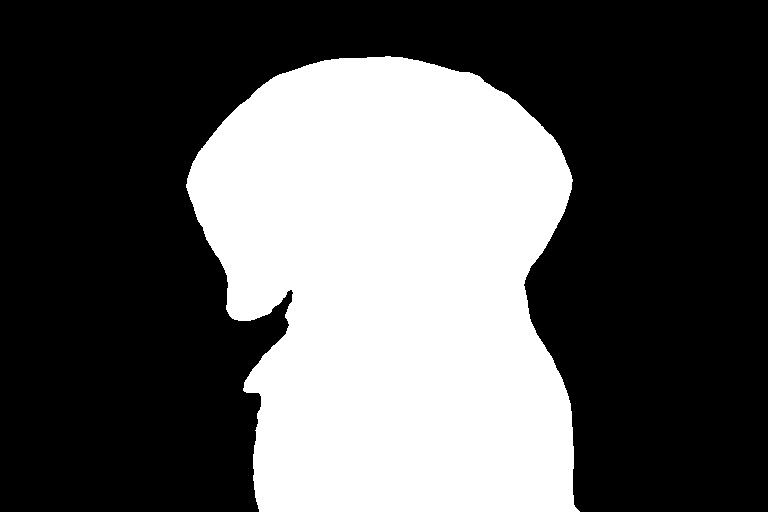

In [6]:
with torch.no_grad():
    # Feed the input tensor to the model. The shape of the input tensor is [batch_size, 3, height, width]
    # The output of the model will be [batch_size, num_classes, height, width]
    logits = model(input_tensor)

    # Take an argmax along the 'num_classes' dimension to produce a segmentation mask
    output_mask = torch.argmax(logits, dim=1)
    # remove the dummy batch dimension and convert to uint8.
    output_mask = output_mask[0].to(torch.uint8)

    # For display purposes, let's convert the image into binary
    output_mask[output_mask > 0] = 255

# convert the tensor to PIL image
output_pil = ToPILImage()(output_mask)
output_pil